In [1]:
# I want to fact-check the February 2021 visualization from the Heritage foundation, 
# on their website with almost no commentary,
# https://datavisualizations.heritage.org/public-health/one-percent-of-us-counties-account-for-bulk-of-covid-19-deaths/
# "Through January 31, there have been 433,401 deaths in the U.S. from COVID-19, but a significant 
#  proportion of those have occurred in just a handful of counties. In fact, the 30 counties with 
#  the most deaths represent 1 percent of all counties, 21 percent of the total U.S. population, 
#  and 28 percent of all U.S. deaths."

In [2]:
# The CDC has an API to serve county-level cases and deaths data:
# https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-County-and-Race-and/k8wy-p9cg

# Initial tests suggest, though, that the data does not reach back to January 2021.
# Update 2023:  the resource has been abandoned by the CDC ca. Sep 2023, superceded by 
# some other database I haven't found yet.

In [3]:
# There is a huge, updated database on the NY Times github page:
# https://github.com/nytimes/covid-19-data 

# That contains a 75-Mb file us-counties.csv.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
counties = pd.read_csv("../data/us-counties.csv")

In [5]:
counties.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [6]:
counties.sample(5)

,date,county,state,fips,cases,deaths
1421455,2021-06-15,Meade,Kentucky,21163.0,2074,26.0
250095,2020-06-18,Kane,Illinois,17089.0,7286,242.0
1567664,2021-07-30,Waldo,Maine,23027.0,1120,21.0
1222171,2021-04-14,Klickitat,Washington,53039.0,691,9.0
1704646,2021-09-10,Red Willow,Nebraska,31145.0,1282,15.0


In [7]:
# Let us grab just the slice of deaths representing Cook Co:
cookco = counties.loc[np.where( counties.fips == 17031)]
cookco.sample(n=10).sort_index()

,date,county,state,fips,cases,deaths
21,2020-01-28,Cook,Illinois,17031.0,1,0.0
196,2020-02-17,Cook,Illinois,17031.0,2,0.0
477,2020-03-03,Cook,Illinois,17031.0,4,0.0
228306,2020-06-11,Cook,Illinois,17031.0,83978,4111.0
303468,2020-07-05,Cook,Illinois,17031.0,92532,4627.0
745801,2020-11-19,Cook,Illinois,17031.0,268284,6148.0
898336,2021-01-05,Cook,Illinois,17031.0,403987,8523.0
1018418,2021-02-11,Cook,Illinois,17031.0,463581,9655.0
1119038,2021-03-14,Cook,Illinois,17031.0,482973,10069.0
1382044,2021-06-03,Cook,Illinois,17031.0,554390,10893.0


In [8]:
len(cookco)

648

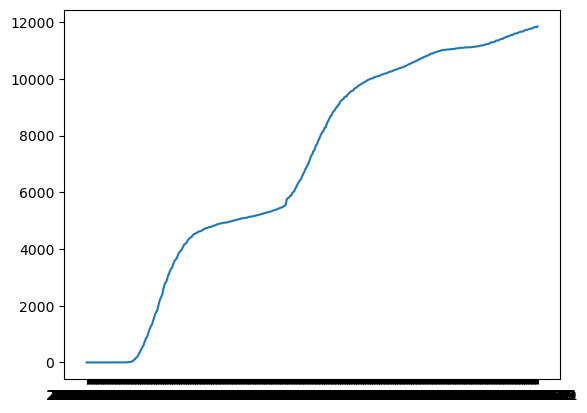

In [9]:
# 600 data points.. less than two years.. check.
plt.plot(cookco.date, cookco.deaths)

In [10]:
# That took a long time and seems like it was plotting nominal time data.   
# Search engine, "pandas to date format," please?
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# Thanks.

In [11]:
d = pd.to_datetime(counties["date"])

In [12]:
d

0         2020-01-21
1         2020-01-22
2         2020-01-23
3         2020-01-24
4         2020-01-24
             ...    
1875093   2021-11-01
1875094   2021-11-01
1875095   2021-11-01
1875096   2021-11-01
1875097   2021-11-01
Name: date, Length: 1875098, dtype: datetime64[ns]

In [13]:
counties["date"] = d
# Note, I'm overwriting the data by reformatting it here.

In [14]:
cookco = counties.loc[np.where( counties.fips == 17031)]

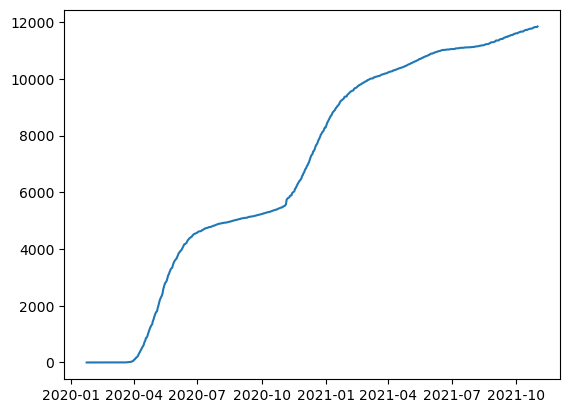

In [15]:
plt.plot(cookco.date, cookco.deaths)

In [16]:
# Now everyone stare at this for a minute.  What is this the graph of ?

In [17]:
#  A:  This is the cumulative sum of a bimodal distribution;
# There were two waves of high death rate separated by 
# periods of quiet. 

In [18]:
# Let us plot per-day deaths:

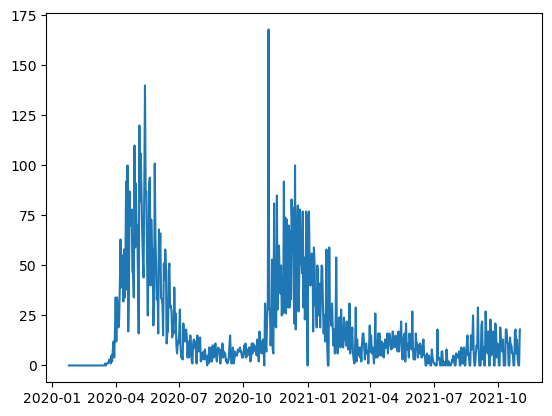

In [19]:
plt.plot(cookco.date[1:], np.diff(cookco.deaths))

(18353.0, 18414.0)

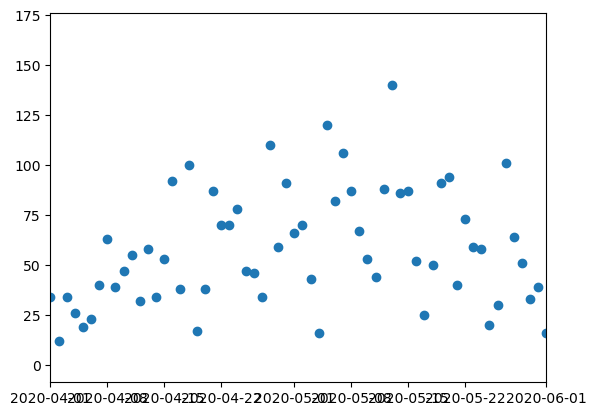

In [20]:
plt.plot(cookco.date[1:], np.diff(cookco.deaths),'o')
plt.xlim ( pd.to_datetime("2020-04-01"), pd.to_datetime("2020-06-01"))

In [21]:
# It's a little noisy.  Differences between points 7 
# days apart will automatically average over 7-day intervals:

In [22]:
cookco["deaths"].shift(7)

3              NaN
6              NaN
11             NaN
16             NaN
21             NaN
            ...   
1859470    11763.0
1862719    11769.0
1865968    11769.0
1869217    11769.0
1872466    11786.0
Name: deaths, Length: 648, dtype: float64

In [23]:
smooth = cookco["deaths"] - cookco["deaths"].shift(7)

In [24]:
cookco.deaths.head()

3     0.0
6     0.0
11    0.0
16    0.0
21    0.0
Name: deaths, dtype: float64

In [25]:
cookco.deaths.shift(7).head(15)

3     NaN
6     NaN
11    NaN
16    NaN
21    NaN
26    NaN
31    NaN
37    0.0
43    0.0
51    0.0
59    0.0
67    0.0
75    0.0
84    0.0
93    0.0
Name: deaths, dtype: float64

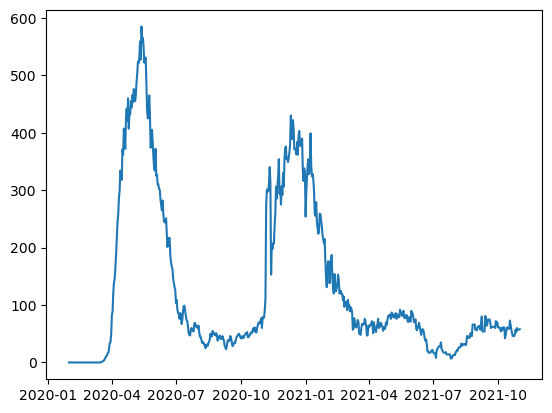

In [26]:
plt.plot(cookco.date, smooth)

In [27]:
# This is overplotting.  (Is overplotting bad?)

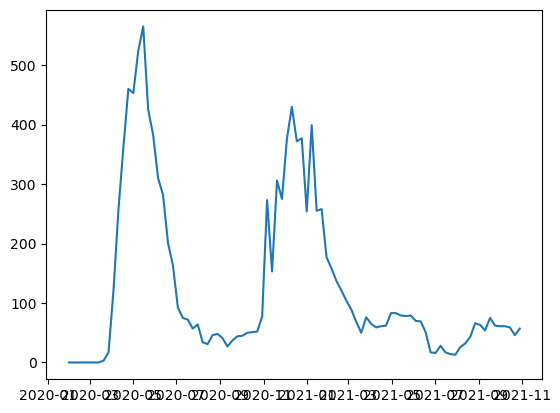

In [28]:
plt.plot(cookco.date[::7], smooth[::7])

In [29]:
# Note a few things.
# 1. The scale changed, we're plotting weekly deaths now.
# 2. There are 7 data points per week, and each data point represents
# the preceding 7 days reporting--so the area under the graph is 7x 
# the true death rate.  This isn't exactly deceptive, but I don't want
# to fool myself either.

In [30]:
# There is an initial wave of deaths in spring 2020, and a 
# second wave of roughly equal intensity November-March 2021.

In [31]:
cookco.deaths

3              0.0
6              0.0
11             0.0
16             0.0
21             0.0
            ...   
1859470    11823.0
1862719    11826.0
1865968    11826.0
1869217    11826.0
1872466    11844.0
Name: deaths, Length: 648, dtype: float64

In [32]:
len(counties)

1875098

In [33]:
# And there were 650 days, so about this many countes
len(counties)/650

2884.766153846154

In [34]:
# Take subset of the data at one point in time for comparison to Heritage
febdata = counties.loc[np.where(counties.date =="2021-01-31")]

In [35]:
len(febdata)

3247

In [36]:
# If I encounter a TypeError at this stage, it is becuase I can't compare an ISO8601 
# date string to an np.datetime64-typed object.

In [37]:
febdata = counties.loc[np.where(counties.date ==np.datetime64("2021-01-31"))]

In [38]:
len(febdata)

3247

In [39]:
febdata.head()

,date,county,state,fips,cases,deaths
982097,2021-01-31,Autauga,Alabama,1001.0,5669,69.0
982098,2021-01-31,Baldwin,Alabama,1003.0,18126,224.0
982099,2021-01-31,Barbour,Alabama,1005.0,1951,40.0
982100,2021-01-31,Bibb,Alabama,1007.0,2307,52.0
982101,2021-01-31,Blount,Alabama,1009.0,5713,100.0


In [40]:
febdata.deaths.sum()

441299.0

In [41]:
# This is more than 433,401 deaths quoted on the Heratige site, but 
# we are clearly in the right ballpark here; the 8000 deaths might be 
# differences in the territorial scope of their query or the data may
# have been revised upward by 1.7%.  Onward!

(array([2.879e+03, 1.410e+02, 6.300e+01, 1.700e+01, 1.900e+01, 1.000e+01,
        1.100e+01, 9.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

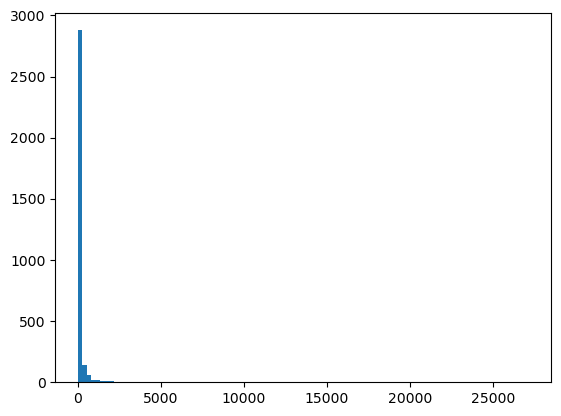

In [42]:
plt.hist(febdata.deaths, bins=100)

/Users/wltrimbl/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 4.433577838129562] is not finite

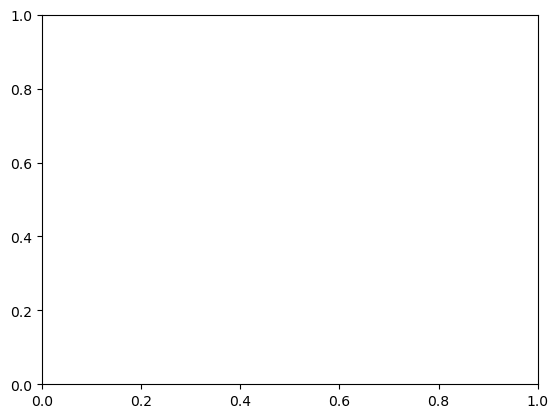

In [43]:
# Ack.  That's not very expressive, is it?
# In vanilla matplotlib, you have to draw your own bins if you want a nice log-histogram.

# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib
    
plt.hist(np.log(febdata.deaths) / np.log(10), bins=100)

(array([ 87.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.,   0.,
          0.,   0.,  59.,   0.,   0.,  62.,   0.,  68.,  50.,   0.,  51.,
         53., 103.,  62.,  98.,  85.,  74., 130., 105., 121., 127., 155.,
        167., 130., 126., 122., 134., 137.,  79.,  90.,  72.,  68.,  58.,
         59.,  48.,  43.,  40.,  43.,  22.,  22.,  18.,  27.,  24.,  12.,
         11.,  10.,  11.,   9.,  10.,  10.,   3.,   6.,   4.,   0.,   2.,
          1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([-2.        , -1.93566422, -1.87132844, -1.80699266, -1.74265688,
        -1.6783211 , -1.61398532, -1.54964954, -1.48531376, -1.42097798,
        -1.3566422 , -1.29230642, -1.22797064, -1.16363486, -1.09929908,
        -1.0349633 , -0.97062752, -0.90629174, -0.84195596, -0.77762018,
        -0.7132844 , -0.64

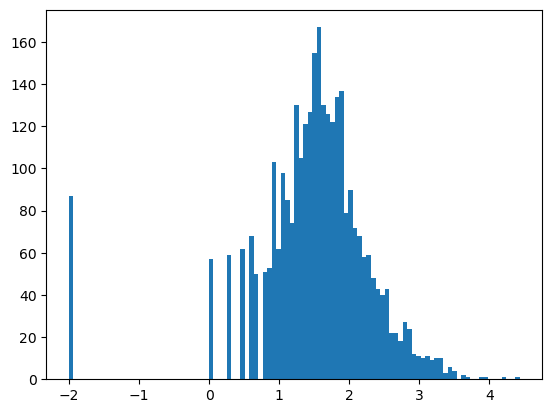

In [44]:
# This is a "can't take logarithm of zero" error.
# I can fix (for now) by adding one one-hundredth
# and remembering that counties with .01 deaths 
# reported zero or NaN deaths in the database.
plt.hist(np.log(febdata.deaths + .01) / np.log(10), bins=100)

In [45]:
# So I have to make my own logarithmicly spaced histogram bins.
bins = np.exp(np.arange(-1,4,.05))

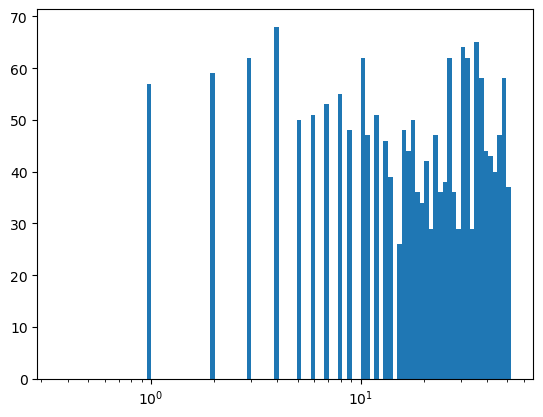

In [46]:
plt.hist(febdata.deaths , bins=bins )
plt.xscale("log")

In [47]:
# What happened to my monomodal distribution?
# Domain is wrong.. only 10^(-0.5) to 10^2

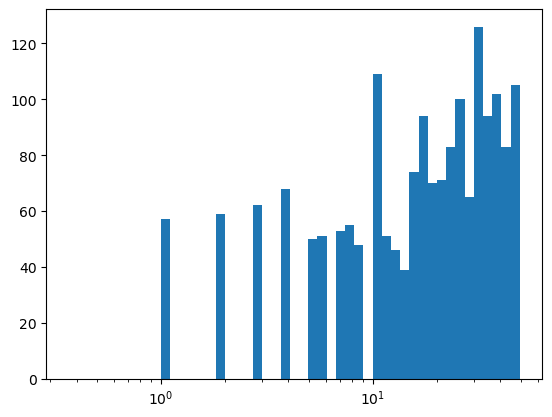

In [48]:
# Try coarser bins?
bins = np.exp(np.arange(-1,4,.1))
plt.hist(febdata.deaths , bins=bins )
plt.xscale("log")

In [ ]:
# That's still not right.  Am I using arange wrong?

In [49]:
bins

array([ 0.36787944,  0.40656966,  0.44932896,  0.4965853 ,  0.54881164,
        0.60653066,  0.67032005,  0.74081822,  0.81873075,  0.90483742,
        1.        ,  1.10517092,  1.22140276,  1.34985881,  1.4918247 ,
        1.64872127,  1.8221188 ,  2.01375271,  2.22554093,  2.45960311,
        2.71828183,  3.00416602,  3.32011692,  3.66929667,  4.05519997,
        4.48168907,  4.95303242,  5.47394739,  6.04964746,  6.68589444,
        7.3890561 ,  8.16616991,  9.0250135 ,  9.97418245, 11.02317638,
       12.18249396, 13.46373804, 14.87973172, 16.44464677, 18.17414537,
       20.08553692, 22.19795128, 24.5325302 , 27.11263892, 29.96410005,
       33.11545196, 36.59823444, 40.44730436, 44.70118449, 49.40244911])

In [50]:
# That's not the right range.  I wanted 10^(-1) to 10^4.
# I wanted to use logs base 10, but forgot that the 
# inverse of log base 10 is not np.exp, it's np.power(10,x)

Text(0.5, 0, 'per-county deaths')

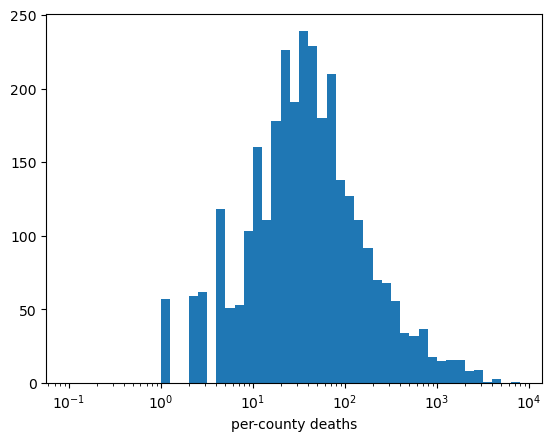

In [51]:
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(febdata.deaths , bins=bins )
plt.xscale("log")
plt.xlabel("per-county deaths")

In [52]:
# And it looks like now we're silently ignoring 
# the counties with no deaths becuase they're offscale:

Text(0.5, 0, 'per-county deaths')

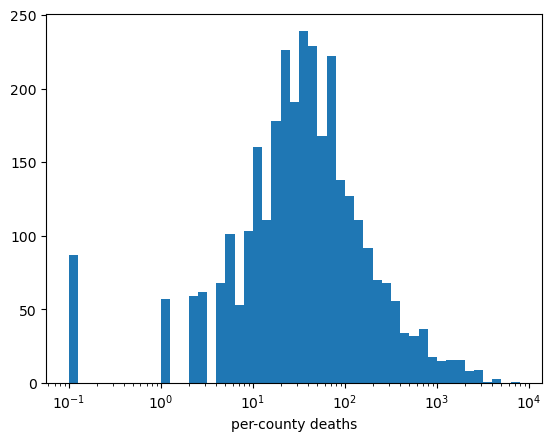

In [53]:
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(febdata.deaths+.1 , bins=bins )
plt.xscale("log")
plt.xlabel("per-county deaths")

In [55]:
# This log-histogram really robs me of any sense of what the 
# distribution is actually like.
# Can we plot deaths by county's death rank?
deathsbycounty = febdata.sort_values("deaths")

Text(0, 0.5, 'Per-county cumulative COVID deaths, Feb 2021')

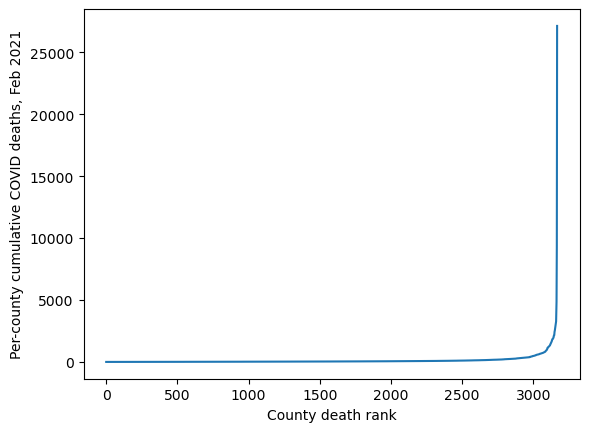

In [56]:
plt.plot(np.arange(len(deathsbycounty)), deathsbycounty.deaths)
plt.xlabel("County death rank")
plt.ylabel("Per-county cumulative COVID deaths, Feb 2021")

In [ ]:
# Rrr.  This still does not make me think I understand.  
# This is not a very expressive graph--one county has 27000 
# deaths, there are 3100 counties; I can tell little else,
# least of all the total body count.


In [ ]:
# Wait a sec, one county with 27,000 deaths, does that make sense?
# The largest county on Heratige's page was LA County with only 17,000.

In [57]:
counties.sort_values("deaths")

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
291986,2020-07-01,Curry,New Mexico,35009.0,165,0.0
1423254,2021-06-15,Daggett,Utah,49009.0,56,0.0
291979,2020-07-01,Unknown,New Jersey,NaN,643,0.0
1423266,2021-06-15,Rich,Utah,49033.0,159,0.0
...,...,...,...,...,...,...
1874255,2021-11-01,Vega Baja,Puerto Rico,72145.0,4451,NaN
1874256,2021-11-01,Vieques,Puerto Rico,72147.0,272,NaN
1874257,2021-11-01,Villalba,Puerto Rico,72149.0,1018,NaN
1874258,2021-11-01,Yabucoa,Puerto Rico,72151.0,1633,NaN


In [59]:
# These NaN values for deaths are getting in my way, I'm going to reset them
# to zero now.
counties[np.isnan(counties.deaths)] =0

In [60]:
# And I better update the data frames representing convenient subsets too
febdata = counties.loc[np.where(counties.date ==np.datetime64("2021-01-31"))]
cookco = counties.loc[np.where( counties.fips == 17031)]
deathsbycounty = febdata.sort_values("deaths")

In [61]:
counties.sort_values("deaths")

,date,county,state,fips,cases,deaths
0,2020-01-21 00:00:00,Snohomish,Washington,53061.0,1,0.0
258730,2020-06-20 00:00:00,Upshur,West Virginia,54097.0,11,0.0
258729,2020-06-20 00:00:00,Tyler,West Virginia,54095.0,3,0.0
258728,2020-06-20 00:00:00,Tucker,West Virginia,54093.0,5,0.0
258727,2020-06-20 00:00:00,Taylor,West Virginia,54091.0,13,0.0
...,...,...,...,...,...,...
1857480,2021-10-27 00:00:00,New York City,New York,NaN,1117924,34544.0
1863978,2021-10-29 00:00:00,New York City,New York,NaN,1119470,34557.0
1870476,2021-10-31 00:00:00,New York City,New York,NaN,1119470,34557.0
1867227,2021-10-30 00:00:00,New York City,New York,NaN,1119470,34557.0


In [62]:
# Now I can see the deathmost counties.  NYC has its own codepoint.
# Check.. is NYC counted twice ?

In [63]:
"Queens" in counties.county.values

False

In [64]:
"Kings" in counties.county.values

True

In [65]:
counties.loc[np.where(counties.county == "Kings")]

,date,county,state,fips,cases,deaths
14154,2020-03-27 00:00:00,Kings,California,6031.0,1,0.0
15936,2020-03-28 00:00:00,Kings,California,6031.0,1,0.0
17825,2020-03-29 00:00:00,Kings,California,6031.0,2,0.0
19802,2020-03-30 00:00:00,Kings,California,6031.0,3,0.0
21876,2020-03-31 00:00:00,Kings,California,6031.0,4,0.0
...,...,...,...,...,...,...
1859055,2021-10-28 00:00:00,Kings,California,6031.0,33485,336.0
1862304,2021-10-29 00:00:00,Kings,California,6031.0,33626,337.0
1865553,2021-10-30 00:00:00,Kings,California,6031.0,33626,337.0
1868802,2021-10-31 00:00:00,Kings,California,6031.0,33626,337.0


In [66]:
counties.loc[np.where(counties.county == "Kings")]["state"].value_counts()

state
California    585
Name: count, dtype: int64

In [67]:
# Now I am convinced that we are not double-counting NYC.
# Our data source does not give us borough-level detail tho.

In [68]:
# The legend says "cumulative"
# meaning cumulative by time.  Let's try cumulative by county. 

Text(0, 0.5, 'Per-county cumulative COVID deaths, Feb 2021')

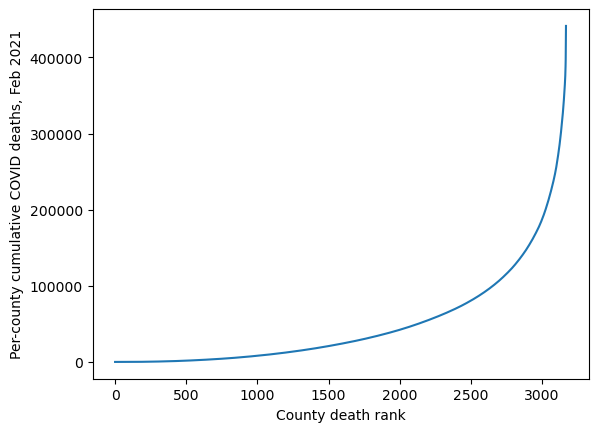

In [69]:
plt.plot(np.arange(len(deathsbycounty)), np.cumsum(deathsbycounty.deaths))
plt.xlabel("County death rank")
plt.ylabel("Per-county cumulative COVID deaths, Feb 2021")

Text(0, 0.5, 'Per-county cumulative COVID deaths, Feb 2021')

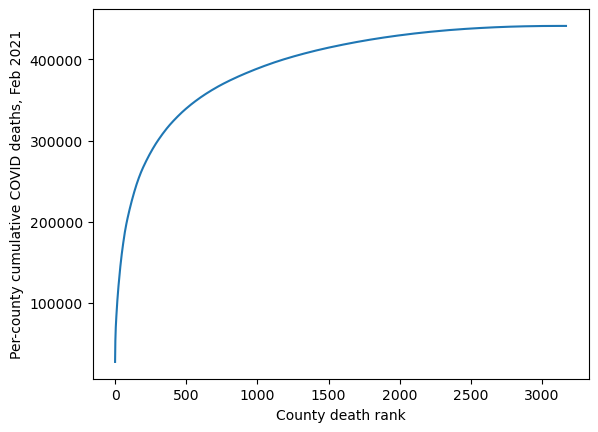

In [70]:
plt.plot(np.arange(len(deathsbycounty)), np.cumsum(deathsbycounty.deaths.sort_values(ascending=False)))
plt.xlabel("County death rank")
plt.ylabel("Per-county cumulative COVID deaths, Feb 2021")

Text(0, 0.5, 'Per-county cumulative COVID deaths, Feb 2021')

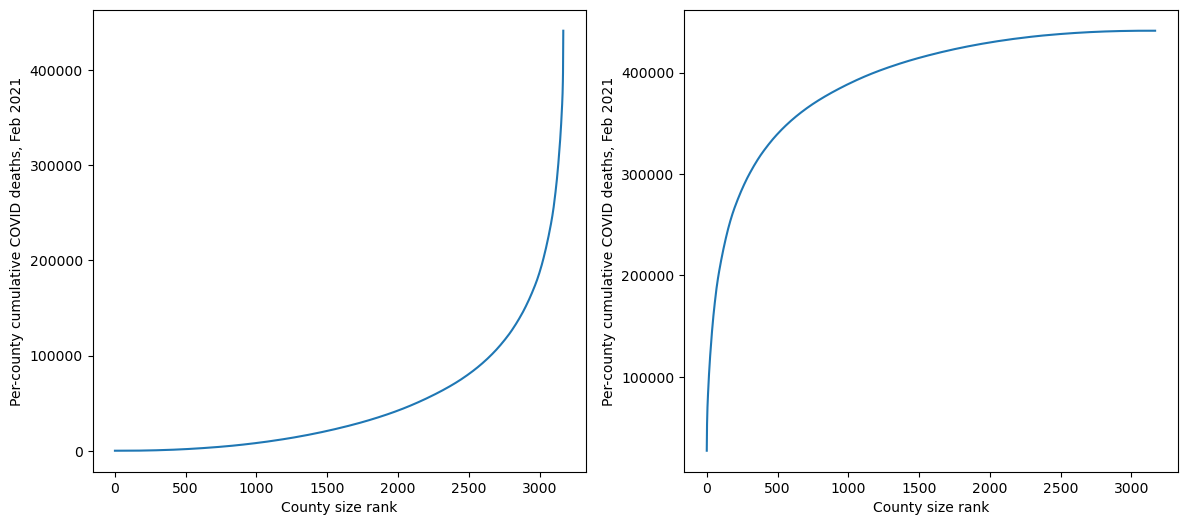

In [71]:
# Let us plot these side-by-side
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(np.arange(len(deathsbycounty)), np.cumsum(deathsbycounty.deaths.sort_values(ascending=True)))
plt.xlabel("County size rank")
plt.ylabel("Per-county cumulative COVID deaths, Feb 2021")
plt.subplot(122)
plt.plot(np.arange(len(deathsbycounty)), np.cumsum(deathsbycounty.deaths.sort_values(ascending=False)))
plt.xlabel("County size rank")
plt.ylabel("Per-county cumulative COVID deaths, Feb 2021")

In [ ]:
# This is getting closer.  Clearly more than half of deaths are in a 
# small fracton of the counties; on linear scales, these graphs
# are the same, but counting from largest to smallest vs. smallest
# to largest matters if you want to transform either axis by,
# for instance, logarithmic scaling.

In [72]:
# top 30 counties, fraction of deaths?
deathsbycounty.head()

,date,county,state,fips,cases,deaths
982482,2021-01-31 00:00:00,Unknown,Florida,NaN,3334,0.0
982328,2021-01-31 00:00:00,Sierra,California,6091.0,43,0.0
983196,2021-01-31 00:00:00,Powell,Kentucky,21197.0,884,0.0
984318,2021-01-31 00:00:00,Unknown,Oklahoma,NaN,134,0.0
984351,2021-01-31 00:00:00,Sherman,Oregon,41055.0,49,0.0


In [73]:
deathsbycounty[-30:]

,date,county,state,fips,cases,deaths
983402,2021-01-31 00:00:00,Oakland,Michigan,26125.0,70447,1898.0
983999,2021-01-31 00:00:00,Westchester,New York,36119.0,94213,1906.0
983899,2021-01-31 00:00:00,Middlesex,New Jersey,34023.0,63956,1923.0
982405,2021-01-31 00:00:00,Fairfield,Connecticut,9001.0,72026,1932.0
983329,2021-01-31 00:00:00,Essex,Massachusetts,25009.0,77363,1969.0
982424,2021-01-31 00:00:00,Broward,Florida,12011.0,172864,2092.0
982406,2021-01-31 00:00:00,Hartford,Connecticut,9003.0,63211,2107.0
984789,2021-01-31 00:00:00,El Paso,Texas,48141.0,113637,2116.0
984939,2021-01-31 00:00:00,Tarrant,Texas,48439.0,216910,2160.0
982468,2021-01-31 00:00:00,Palm Beach,Florida,12099.0,107240,2166.0


In [74]:
np.sum(deathsbycounty.deaths[-30:]) / np.sum(deathsbycounty.deaths)

0.2952374693801708

In [75]:
np.sum(deathsbycounty.deaths[-30:])

130288.0

In [76]:
counties.sort_values("deaths")[-10:]

,date,county,state,fips,cases,deaths
1844482,2021-10-23 00:00:00,New York City,New York,NaN,1113762,34502.0
1841232,2021-10-22 00:00:00,New York City,New York,NaN,1113762,34502.0
1850982,2021-10-25 00:00:00,New York City,New York,NaN,1116428,34531.0
1854231,2021-10-26 00:00:00,New York City,New York,NaN,1117283,34533.0
1860729,2021-10-28 00:00:00,New York City,New York,NaN,1117924,34544.0
1857480,2021-10-27 00:00:00,New York City,New York,NaN,1117924,34544.0
1863978,2021-10-29 00:00:00,New York City,New York,NaN,1119470,34557.0
1870476,2021-10-31 00:00:00,New York City,New York,NaN,1119470,34557.0
1867227,2021-10-30 00:00:00,New York City,New York,NaN,1119470,34557.0
1873725,2021-11-01 00:00:00,New York City,New York,NaN,1122970,34580.0


In [ ]:
deathsbycounty[-10:]

In [77]:
# Now we need to go fetch population by county 
# This table purports to assemble 2020 census data in a usable table
# https://github.com/nytimes/covid-19-data/issues/180
population = pd.read_json("https://raw.githubusercontent.com/Zoooook/CoronavirusTimelapse/master/static/population.json")

In [78]:
population.head()

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
0,78,78999,104680,Virgin Islands,Unknown,NaN
1,72,72999,3386941,Puerto Rico,Unknown,NaN
2,66,66999,165768,Guam,Unknown,NaN
3,69,69999,56882,Northern Mariana Islands,Unknown,NaN
4,1,1001,55200,Alabama,Autauga,NaN


In [79]:
population.sample(5)

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
2587,48,48127,10663,Texas,Dimmit,NaN
3081,55,55067,19164,Wisconsin,Langlade,NaN
2321,45,45009,14600,South Carolina,Bamberg,NaN
720,18,18039,203604,Indiana,Elkhart,NaN
2104,39,39121,14443,Ohio,Noble,NaN


In [80]:
population.population.sum()

326617301

In [ ]:
# 326 million.. this is more recent than the 2010 census then.

In [81]:
countiesbypop = population.population.sort_values(ascending=False)

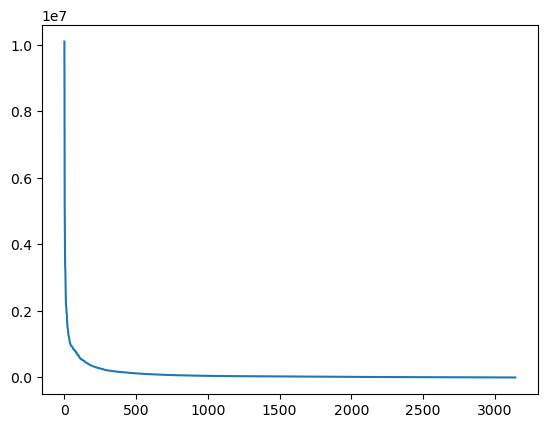

In [82]:
plt.plot(np.arange(len(countiesbypop)), countiesbypop)

Text(0, 0.5, 'Cumulative population')

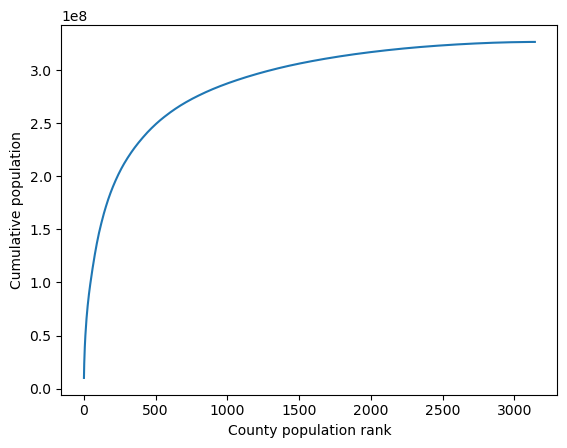

In [83]:
plt.plot(np.arange(len(countiesbypop)), np.cumsum(countiesbypop))
plt.xlabel("County population rank")
plt.ylabel("Cumulative population")

In [84]:
deathsbycountyrev = febdata.deaths.sort_values(ascending=False)

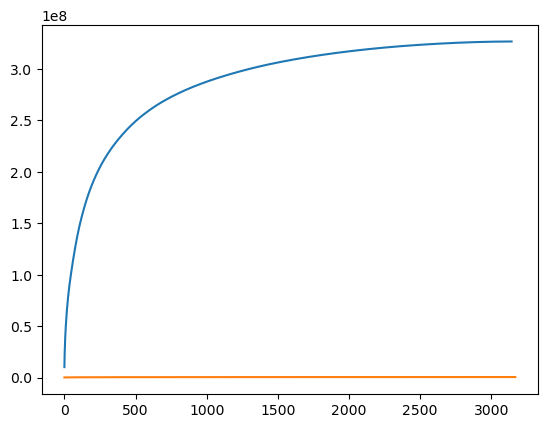

In [85]:
plt.plot(np.arange(len(countiesbypop)), np.cumsum(countiesbypop))
plt.plot(np.arange(len(deathsbycountyrev)), np.cumsum(deathsbycountyrev))

In [ ]:
# -1 point for not being expressive.  326 million and 400k don't
# fit on the same graph.  Log transform?

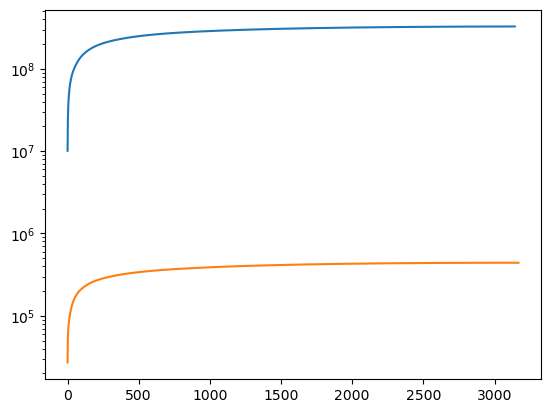

In [86]:
plt.plot(np.arange(len(countiesbypop)), np.cumsum(countiesbypop))
plt.plot(np.arange(len(deathsbycountyrev)), np.cumsum(deathsbycountyrev))
plt.yscale("log")

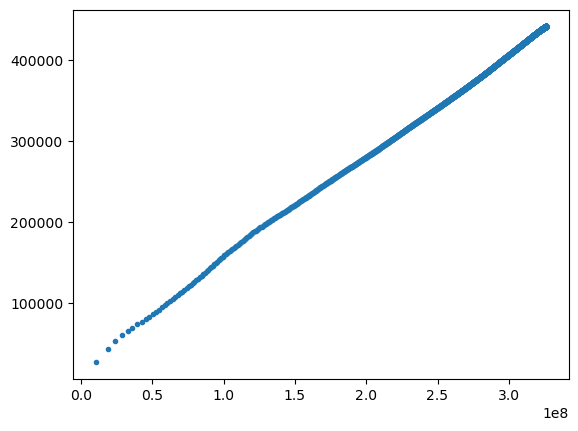

In [88]:
plt.plot( np.cumsum(countiesbypop)[0:3000],  np.cumsum(deathsbycountyrev)[0:3000], '.')
#plt.yscale("log")

In [ ]:
# I am being intellecutally dishonest here, watch out. 
# Because I've not joined the two tables on the fips county id yet,
# I am presenting two sorted series of counties 
# that have been sorted by different columns
# as if they are the same.  One is sorted by population;
# one is sorted by deaths.  But each row has its own identity, 
# and there is a one-to-one relationship betwen population and
# deaths that I have NOT yet shown.

In [89]:
population.head(1)

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
0,78,78999,104680,Virgin Islands,Unknown,NaN


In [101]:
population.sample(10)

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
1965,37,37149,20458,North Carolina,Polk,NaN
1192,23,23023,35277,Maine,Sagadahoc,NaN
1604,30,30003,13376,Montana,Big Horn,NaN
140,5,5051,98296,Arkansas,Garland,NaN
2575,48,48103,4839,Texas,Crane,NaN
2997,54,54009,22772,West Virginia,Brooke,NaN
7,1,1007,22527,Alabama,Bibb,NaN
3086,55,55077,15207,Wisconsin,Marquette,NaN
3057,55,55019,34491,Wisconsin,Clark,NaN
2799,49,49043,40511,Utah,Summit,NaN


In [90]:
febdata.head(1)

,date,county,state,fips,cases,deaths
982097,2021-01-31 00:00:00,Autauga,Alabama,1001.0,5669,69.0


In [ ]:
# I have to note that the deaths data encodes fips as a 
# floating point number, while the population data enocdes 
# it as an integer.  This is probably enough to prevent me
# from joining it.  


In [91]:
febdata.fips.dtype

dtype('float64')

In [92]:
# can I recast it as an integer?
febdata.fips.astype("int64")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# There are some bad values in there.

In [93]:
# Can I ignore errors?
fips= febdata.fips.astype("int64", errors="ignore")

In [94]:
fips.head()

982097    1001.0
982098    1003.0
982099    1005.0
982100    1007.0
982101    1009.0
Name: fips, dtype: float64

In [95]:
fips.dtype

dtype('float64')

In [96]:
# No.  If I ignore errors the result isn't in an integer data type. 
fips= febdata.fips.astype(np.int64, errors="ignore")
fips.dtype

dtype('float64')

In [ ]:
# How many bad values are there?

In [97]:
np.isinf(fips).sum()

0

In [98]:
np.isnan(fips).sum()

29

In [99]:
# Let's look at them:
counties.loc[np.isnan(counties.fips)]

,date,county,state,fips,cases,deaths
416,2020-03-01 00:00:00,New York City,New York,NaN,1,0.0
418,2020-03-01 00:00:00,Unknown,Rhode Island,NaN,2,0.0
448,2020-03-02 00:00:00,New York City,New York,NaN,1,0.0
450,2020-03-02 00:00:00,Unknown,Rhode Island,NaN,2,0.0
482,2020-03-03 00:00:00,New York City,New York,NaN,2,0.0
...,...,...,...,...,...,...
1874252,2021-11-01 00:00:00,Unknown,Puerto Rico,NaN,5390,3234.0
1874264,2021-11-01 00:00:00,Unknown,Rhode Island,NaN,13311,14.0
1874465,2021-11-01 00:00:00,Unknown,Tennessee,NaN,7884,120.0
1874752,2021-11-01 00:00:00,Unknown,Utah,NaN,2478,47.0


In [100]:
counties.loc[np.isnan(counties.fips)].sample(20)

,date,county,state,fips,cases,deaths
1541662,2021-07-22 00:00:00,Unknown,Louisiana,NaN,391,0.0
617820,2020-10-10 00:00:00,Unknown,Puerto Rico,NaN,1511,728.0
668559,2020-10-26 00:00:00,Unknown,Maryland,NaN,0,10.0
1620255,2021-08-15 00:00:00,Unknown,New Jersey,NaN,846,0.0
677384,2020-10-29 00:00:00,Unknown,Delaware,NaN,91,0.0
970314,2021-01-27 00:00:00,Unknown,Maine,NaN,9,0.0
1201010,2021-04-08 00:00:00,Unknown,Minnesota,NaN,556,78.0
1153303,2021-03-24 00:00:00,Unknown,Rhode Island,NaN,11941,16.0
525935,2020-09-12 00:00:00,Unknown,Maryland,NaN,0,11.0
1765161,2021-09-29 00:00:00,Unknown,Georgia,NaN,4586,7.0


In [ ]:
# Ugh oh.  These are deaths I probably want to count, despite
# the fact that I won't be able to join them with population.  
# Only 29 bad fips fields in febdata:

In [102]:
febdata.loc[np.isnan(febdata.fips)]

,date,county,state,fips,cases,deaths
982187,2021-01-31 00:00:00,Unknown,Alaska,NaN,236,0.0
982277,2021-01-31 00:00:00,Unknown,Arkansas,NaN,2907,0.0
982412,2021-01-31 00:00:00,Unknown,Connecticut,NaN,822,7.0
982417,2021-01-31 00:00:00,Unknown,Delaware,NaN,182,0.0
982482,2021-01-31 00:00:00,Unknown,Florida,NaN,3334,0.0
982631,2021-01-31 00:00:00,Unknown,Georgia,NaN,4222,10.0
982647,2021-01-31 00:00:00,Unknown,Guam,NaN,8556,130.0
982788,2021-01-31 00:00:00,Unknown,Illinois,NaN,0,106.0
982980,2021-01-31 00:00:00,Unknown,Iowa,NaN,1065,0.0
983090,2021-01-31 00:00:00,Unknown,Kansas,NaN,0,725.0


In [103]:
febdata.loc[np.isnan(febdata.fips)].deaths.sum()

30878.0

In [ ]:
# Amounting to 31,000 deaths.

In [ ]:
27138.0+1829.0

In [104]:
febdata.fips.value_counts()

fips
1001.0     1
39097.0    1
39101.0    1
39103.0    1
39105.0    1
          ..
21115.0    1
21117.0    1
21119.0    1
21121.0    1
56045.0    1
Name: count, Length: 3140, dtype: int64

In [ ]:
# 31,000 deaths, almost all of which are from NYC and Puerto Rico.
# I'm willing to treat them as special cases.

In [105]:
# Some trial-and-error suggests that I must fix NaN's first,
# then change the type to int.
febdata.loc[np.isnan(febdata.fips),"fips"] = 999999
fips = febdata.fips.astype(np.int64)
fips.dtype

dtype('int64')

In [106]:
fips.head()

982097    1001
982098    1003
982099    1005
982100    1007
982101    1009
Name: fips, dtype: int64

In [107]:
np.isnan(febdata.fips).sum()

0

In [108]:
febdata["fips"] = febdata.fips.astype(np.int64)

In [109]:
np.isnan(counties.fips).sum()

17137

In [110]:
counties.head(1)

,date,county,state,fips,cases,deaths
0,2020-01-21 00:00:00,Snohomish,Washington,53061.0,1,0.0


In [111]:
# That seemed to work for febdata, apply to counties
counties.loc[np.isnan(counties.fips),"fips"] = 999999

In [112]:
np.isnan(counties.fips).sum()

0

In [113]:
counties["fips"] = counties.fips.astype(np.int64)
counties.fips.dtype

dtype('int64')

In [114]:
febdata.loc[np.isnan(febdata.fips)]

,date,county,state,fips,cases,deaths


In [115]:
population.loc[population.region == "Puerto Rico"]

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
1,72,72999,3386941,Puerto Rico,Unknown,NaN


In [116]:
population.loc[population.subregion == "New York City"]

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
1890,36,36998,8443713,New York,New York City,NaN


In [117]:
febdata[febdata.county == "New York City"]

,date,county,state,fips,cases,deaths
983972,2021-01-31 00:00:00,New York City,New York,999999,608862,27138.0


In [118]:
febdata.loc[febdata.county == "New York City","fips"] = 36998

In [119]:
# and I should change this for PR and counties too
febdata.loc[febdata.state == "Puerto Rico","fips"] = 72999
counties.loc[counties.county == "New York City","fips"] = 36998
counties.loc[counties.state == "Puerto Rico","fips"] = 72999


In [120]:
febdata.head(1)

,date,county,state,fips,cases,deaths
982097,2021-01-31 00:00:00,Autauga,Alabama,1001,5669,69.0


In [121]:
febdata.fips.dtype

dtype('int64')

In [122]:
population.head(1)

,us_state_fips,us_county_fips,population,region,subregion,nyt_population
0,78,78999,104680,Virgin Islands,Unknown,NaN


In [123]:
# duplicate the field with a different name for convenience
population["fips"]= population.us_county_fips

In [124]:
deathswithpop= counties.join(population, "fips")

ValueError: columns overlap but no suffix specified: Index(['fips'], dtype='object')

In [125]:
# No suffix specified.. ok, here's a suffix
deathswithpop= counties.join(population, "fips", rsuffix="_pop")

In [127]:
deathswithpop.sample(5)

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population,fips_pop
1676122,2021-09-01 00:00:00,York,South Carolina,45091,38681,420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777130,2020-11-28 00:00:00,Houston,Texas,48225,574,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1454575,2021-06-25 00:00:00,Rock,Nebraska,31149,151,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1485734,2021-07-05 00:00:00,Fayette,Georgia,13113,9183,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134015,2020-05-11 00:00:00,Delaware,Iowa,19055,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Well maybe it never joins Snohomish county for some reason...
deathswithpop.loc[::1000]

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population,fips_pop
0,2020-01-21 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,2020-03-10 00:00:00,Fresno,California,6019,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,2020-03-14 00:00:00,Clay,Florida,12019,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000,2020-03-16 00:00:00,Grafton,New Hampshire,33009,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000,2020-03-18 00:00:00,St. John the Baptist,Louisiana,22095,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871000,0,0,0,0,0,0.0,78.0,78999.0,104680.0,Virgin Islands,Unknown,NaN,78999.0
1872000,2021-11-01 00:00:00,Little River,Arkansas,5081,2059,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1873000,2021-11-01 00:00:00,Lafourche,Louisiana,22057,17927,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1874000,2021-11-01 00:00:00,Adair,Oklahoma,40001,4878,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


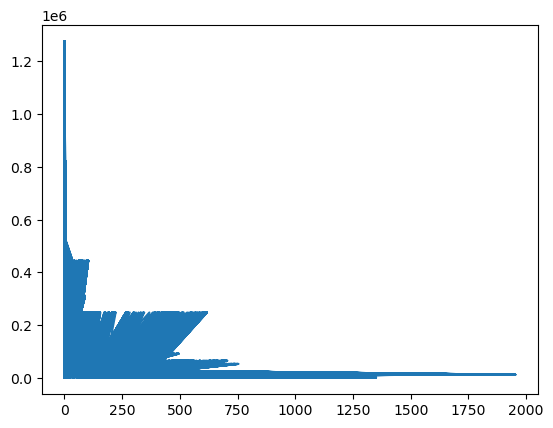

In [129]:
#  Most of these are not joined
plt.plot(deathswithpop.deaths, deathswithpop.population)

Text(0, 0.5, 'deaths')

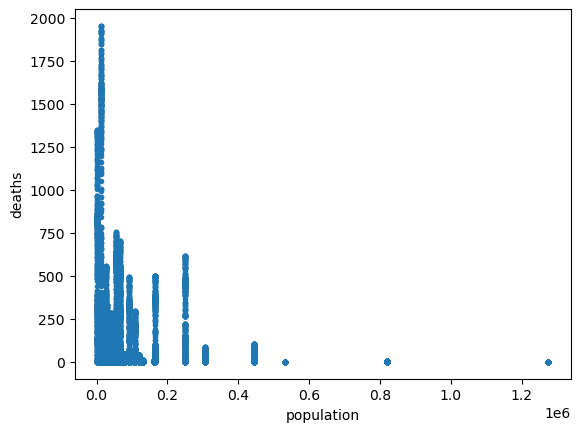

In [130]:
# Turn off the lines...
plt.plot(deathswithpop.population, deathswithpop.deaths,'.')
plt.xlabel("population")
plt.ylabel("deaths")

Text(0, 0.5, 'deaths')

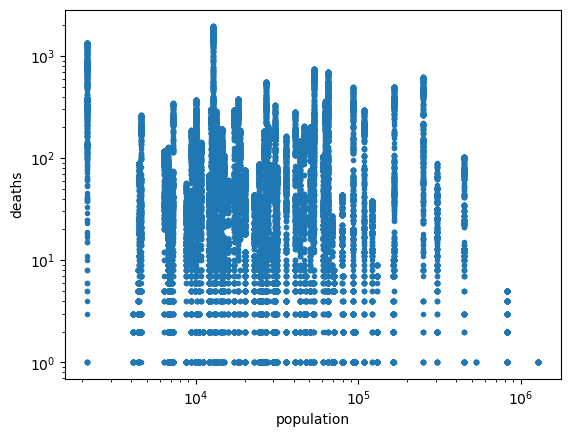

In [131]:
# loglog plot..
plt.plot(deathswithpop.population, deathswithpop.deaths,'.')
plt.xscale("log"); plt.yscale("log")
plt.xlabel("population")
plt.ylabel("deaths")


In [132]:
# This does not look right. County population should not have
# many values for well-separated points in the middle of the domain.
# Unless I'm plotting all the time points on top of each other.  D'oh.

febdata = deathswithpop.loc[np.where(deathswithpop.date ==np.datetime64("2021-01-31"))]

In [133]:
# Check that numbers add up!
febdata.population.sum()

6707680.0

In [134]:
febdata.deaths.sum()

441299.0

In [ ]:
# All the deaths, but almost none of the population.  7M / 326M 

In [135]:
# Let's spot-check Wyandotte County, KS.  Why did it not join?
population.loc[np.where(population.subregion=="Wyandotte")]

,us_state_fips,us_county_fips,population,region,subregion,nyt_population,fips
996,20,20209,164345,Kansas,Wyandotte,NaN,20209


In [136]:
counties.loc[ np.where(counties.county == "Wyandotte")]

,date,county,state,fips,cases,deaths
1458,2020-03-12 00:00:00,Wyandotte,Kansas,20209,1,1.0
1731,2020-03-13 00:00:00,Wyandotte,Kansas,20209,1,1.0
2066,2020-03-14 00:00:00,Wyandotte,Kansas,20209,1,1.0
2462,2020-03-15 00:00:00,Wyandotte,Kansas,20209,1,1.0
2907,2020-03-16 00:00:00,Wyandotte,Kansas,20209,1,1.0
...,...,...,...,...,...,...
1859854,2021-10-28 00:00:00,Wyandotte,Kansas,20209,27989,376.0
1863103,2021-10-29 00:00:00,Wyandotte,Kansas,20209,28034,376.0
1866352,2021-10-30 00:00:00,Wyandotte,Kansas,20209,28034,376.0
1869601,2021-10-31 00:00:00,Wyandotte,Kansas,20209,28034,376.0


In [137]:
deathswithpop= counties.join(population, "fips", rsuffix="_pop")
deathswithpop[::10000]

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population,fips_pop
0,2020-01-21 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,2020-03-24 00:00:00,St. James,Louisiana,22093,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20000,2020-03-30 00:00:00,Fayette,Georgia,13113,42,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30000,2020-04-03 00:00:00,Union,Ohio,39159,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000,2020-04-07 00:00:00,Darlington,South Carolina,45031,29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830000,2021-10-19 00:00:00,Appling,Georgia,13001,3466,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1840000,2021-10-22 00:00:00,Jo Daviess,Illinois,17085,2166,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850000,2021-10-25 00:00:00,Woodbury,Iowa,19193,19215,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860000,2021-10-28 00:00:00,Jefferson,Louisiana,22051,69492,1162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
# Not joined
deathswithpop.deaths.sum()

223298627.0

In [139]:
deathswithpop.head()

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population,fips_pop
0,2020-01-21 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-22 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-23 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-24 00:00:00,Cook,Illinois,17031,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-24 00:00:00,Snohomish,Washington,53061,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
feb = deathswithpop.loc[np.where(deathswithpop.date ==np.datetime64("2021-01-31"))]


In [141]:
len(feb)

3169

In [142]:
feb.population.sum()

6707680.0

In [143]:
len(feb[feb.population>0])

94

In [144]:
# A little bit of a puzzle why only 94 counties out of 3169 joined.
# Search engine...
# https://stackoverflow.com/questions/10114399/pandas-simple-join-not-working
# Use pd.DataFrame.merge; pd.join pays too much attention to indexes, and we often
# want to join on data columns that aren't suitable indexes.

deathswithpop= counties.merge(population, on="fips")
feb = deathswithpop.loc[np.where(deathswithpop.date ==np.datetime64("2021-01-31"))]


In [145]:
feb.population.sum()

325437513

In [146]:
feb.deaths.sum()

439361.0

In [ ]:
# So we lost a million population and two thousand deaths, but most rows merged!

In [147]:
len(feb.loc[feb.population>0])

3135

In [148]:
feb.head()

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population
376,2021-01-31 00:00:00,Snohomish,Washington,53061,28373,488.0,53,53061,786620,Washington,Snohomish,NaN
1024,2021-01-31 00:00:00,Cook,Illinois,17031,453634,9374.0,17,17031,5223719,Illinois,Cook,NaN
1671,2021-01-31 00:00:00,Orange,California,6059,245978,3062.0,6,6059,3164182,California,Orange,NaN
2317,2021-01-31 00:00:00,Maricopa,Arizona,4013,472760,7462.0,4,4013,4253913,Arizona,Maricopa,NaN
2963,2021-01-31 00:00:00,Los Angeles,California,6037,1117346,16770.0,6,6037,10098052,California,Los Angeles,NaN


In [149]:
feb[::100]

,date,county,state,fips,cases,deaths,us_state_fips,us_county_fips,population,region,subregion,nyt_population
376,2021-01-31 00:00:00,Snohomish,Washington,53061,28373,488.0,53,53061,786620,Washington,Snohomish,NaN
61472,2021-01-31 00:00:00,Harford,Maryland,24025,11372,207.0,24,24025,251025,Maryland,Harford,NaN
121676,2021-01-31 00:00:00,Fond du Lac,Wisconsin,55039,12484,93.0,55,55039,102315,Wisconsin,Fond du Lac,NaN
181630,2021-01-31 00:00:00,Jefferson,Tennessee,47089,5129,84.0,47,47089,53247,Tennessee,Jefferson,NaN
241413,2021-01-31 00:00:00,Waseca,Minnesota,27161,1968,16.0,27,27161,18809,Minnesota,Waseca,NaN
301006,2021-01-31 00:00:00,Jackson,Mississippi,28059,11471,196.0,28,28059,142014,Mississippi,Jackson,NaN
360445,2021-01-31 00:00:00,Moore,North Carolina,37125,7052,130.0,37,37125,95629,North Carolina,Moore,NaN
419777,2021-01-31 00:00:00,Livingston,Michigan,26093,9645,113.0,26,26093,188482,Michigan,Livingston,NaN
479032,2021-01-31 00:00:00,Riley,Kansas,20161,5934,30.0,20,20161,75296,Kansas,Riley,NaN
538232,2021-01-31 00:00:00,Campbell,Wyoming,56005,4624,53.0,56,56005,47708,Wyoming,Campbell,NaN


In [ ]:
# I am now satisfied that my table is joined.

In [150]:
feb["percapitadeaths"] = feb.deaths / feb.population

Text(0, 0.5, 'County Deaths')

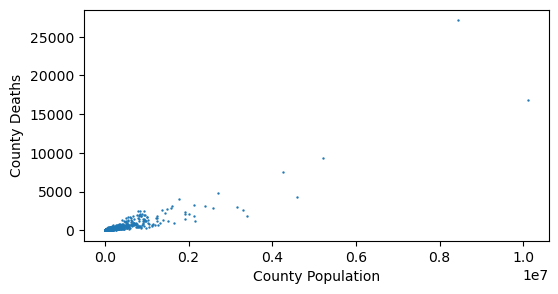

In [157]:

plt.figure(figsize=(6,3))

plt.scatter(feb.population, feb.deaths, s=0.5)
plt.xlabel("County Population")
plt.ylabel("County Deaths")

Text(0, 0.5, 'County Deaths')

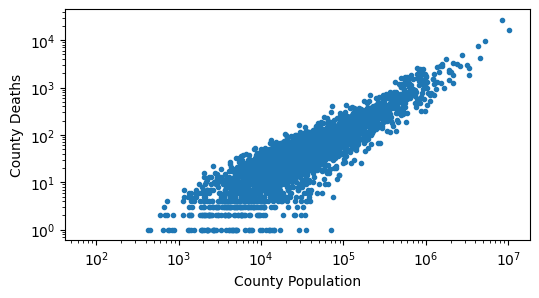

In [155]:
plt.figure(figsize=(6,3))
plt.loglog(feb.population, feb.deaths,'.')
plt.xlabel("County Population")
plt.ylabel("County Deaths")

In [ ]:
# What do you see in this graph?


Text(0.5, 0, 'Per capita death rate')

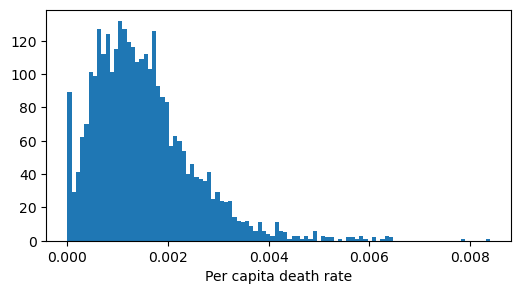

In [159]:
# Just for kicks... histogram of per capita death rate?
plt.figure(figsize=(6,3))

plt.hist (feb.percapitadeaths, bins=100)
plt.xlabel("Per capita death rate")

In [160]:
# This looks believable, but this is not the graph on which 
# we will find the truth. 
# WE ARE COUNTING THE WRONG THINGS, as usual.
# Imagine the headline "50% of counties report death rates above
feb.percapitadeaths.median()
# .00134  ( one death per 742 population).  This generalizes how?
# The counties do not all have the same weights.

0.0013469309216855877

In [ ]:
# To get at the Heritige Foundation's implicit question -- how can we show
# the difference between death toll in large and small (population, before-the-fact)
# counties, I suggest plotting cumulative population (small to large) against 
# cumulative deaths.

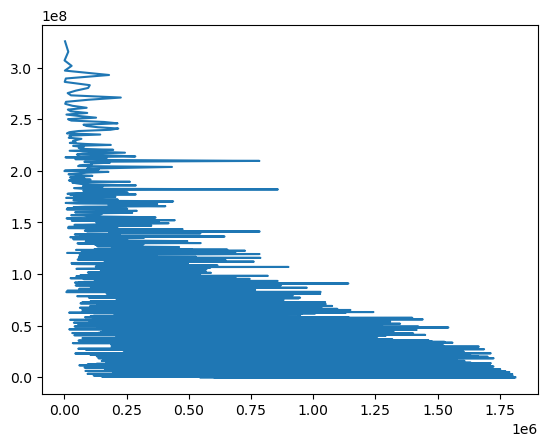

In [162]:
# Och, forgot to sort by population.
plt.plot( feb.population.sort_values(ascending=True).cumsum())

In [ ]:
# Uh, what?   
feb.population.sort_values()

In [ ]:
# plt.plot wants to plot using the index.  ok.  I can plot against rank with np.arange(len(feb.population)

Text(0, 0.5, 'Cumulative population')

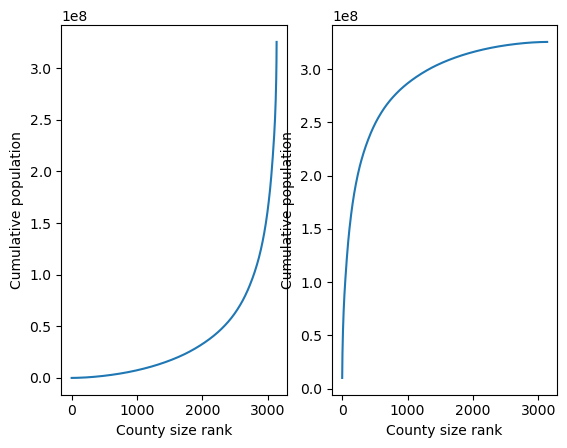

In [163]:
# This gives me cumulative population from smallest to biggest... 
plt.subplot(121);
plt.plot(np.arange(len(feb.population)), feb.population.sort_values(ascending=True).cumsum())
# And biggest to smallest... 
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")

plt.subplot(122)
plt.plot(np.arange(len(feb.population)), feb.population.sort_values(ascending=False).cumsum())
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")

In [ ]:
# Consider (as the Heratige people did) this as a data transformation: 
# this exaggerates small counties by changing the x-axis.

Text(0, 0.5, 'Cumulative population')

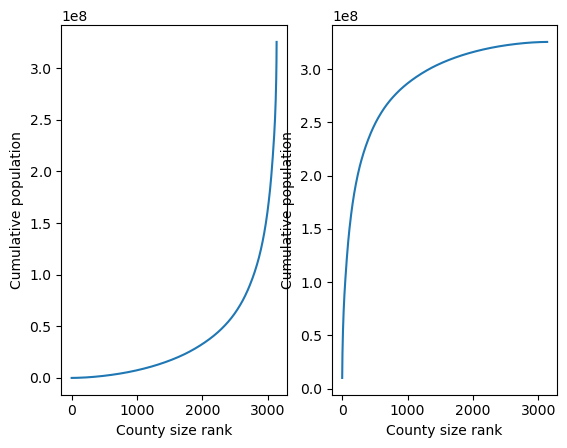

In [164]:
# but I'm using sort_values on feb.population (a series); I need the whole dataframe for 
# the next step. 
plt.subplot(121);
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=True).population.cumsum())
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")
plt.subplot(122)
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).population.cumsum())
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")

Text(0, 0.5, 'Cumulative population')

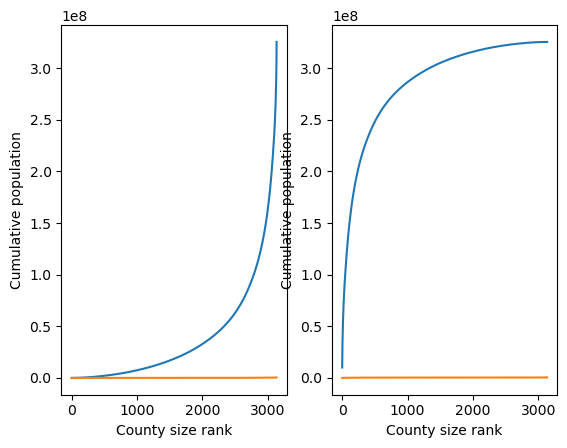

In [165]:
# This gives me the same thing, but also gives me access to deaths in the same order.
# but I'm using sort_values on feb.population (a series); I need the whole dataframe for 
# the next step. 
plt.subplot(121);
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=True).population.cumsum())
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=True).deaths.cumsum())
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")
plt.subplot(122)
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).population.cumsum())
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).deaths.cumsum())
plt.xlabel("County size rank")
plt.ylabel("Cumulative population")

Text(0.5, 0, 'County population rank (large to small)')

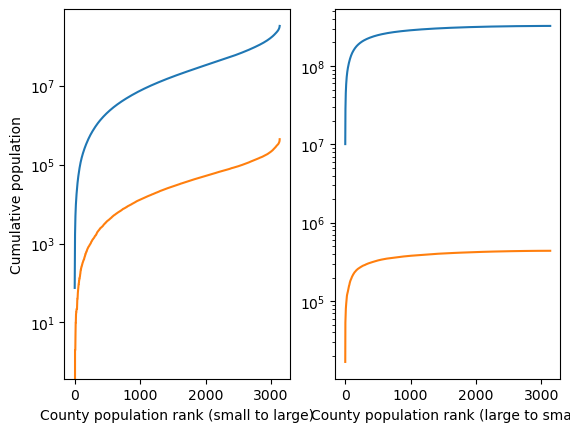

In [166]:
# Make it logarithmic just to make sure we have what we expect
plt.subplot(121);
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=True).population.cumsum())
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=True).deaths.cumsum())
plt.ylabel("Cumulative population")
plt.xlabel("County population rank (small to large)")
plt.yscale("log")
plt.subplot(122)
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).population.cumsum())
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).deaths.cumsum())
plt.yscale("log")
#plt.ylabel("Cumulative population")
plt.xlabel("County population rank (large to small)")


2963       16770.0
16009      43908.0
1024       53282.0
29389      57539.0
2317       65001.0
            ...   
287916    196253.0
75352     198120.0
154076    199248.0
132478    199904.0
39085     200491.0
Name: deaths, Length: 100, dtype: float64

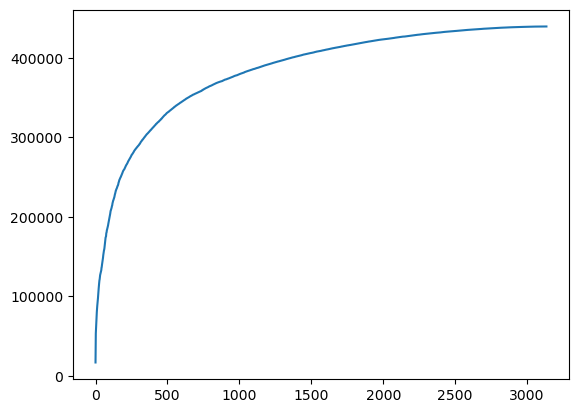

In [167]:
plt.plot(np.arange(len(feb.population)), feb.sort_values("population", ascending=False).deaths.cumsum())
feb.sort_values("population", ascending=False).deaths.cumsum()[0:100]

Text(0, 0.5, 'cumulative COVID deaths (Feb 2021) n = 411k')

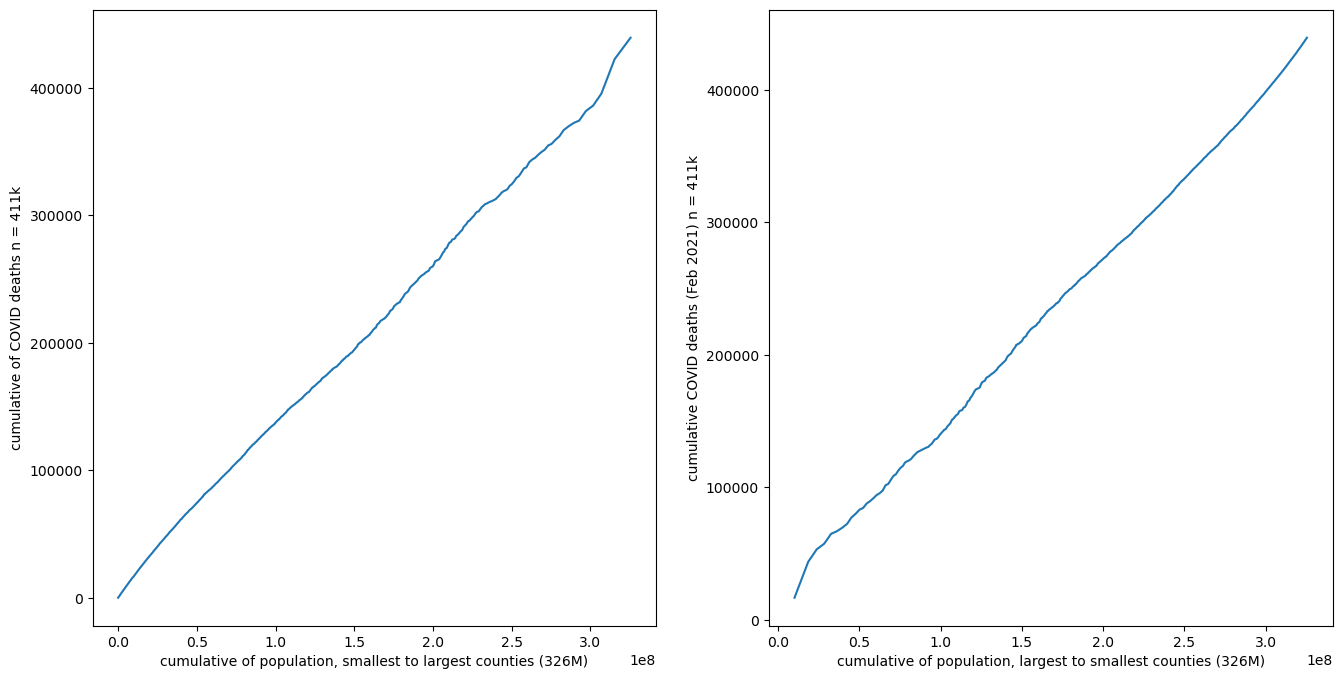

In [168]:
# And now for the finish, plot cumulative population vs. cumulative deaths.
# Before we plot it, we expect it will go from 0,0 to 326M, 411k.
plt.figure(figsize=(16,8))
plt.subplot(121);
plt.plot( feb.sort_values("population", ascending=True).population.cumsum(), feb.sort_values("population", ascending=True).deaths.cumsum())
plt.xlabel("cumulative of population, smallest to largest counties (326M)")
plt.ylabel("cumulative of COVID deaths n = 411k")

plt.subplot(122)
plt.plot( feb.sort_values("population", ascending=False).population.cumsum(), feb.sort_values("population", ascending=False).deaths.cumsum())
plt.xlabel("cumulative of population, largest to smallest counties (326M)")
plt.ylabel("cumulative COVID deaths (Feb 2021) n = 411k")


In [ ]:
# ?!?!?!

In [ ]:
# I'm using calculus to make my data smoother.
# Yeah, there's a tiny kink on the left hand corner, but we kind of already knew that
# King County, WA, and NYC were the hardest hit by the disease in Q1 2020.  

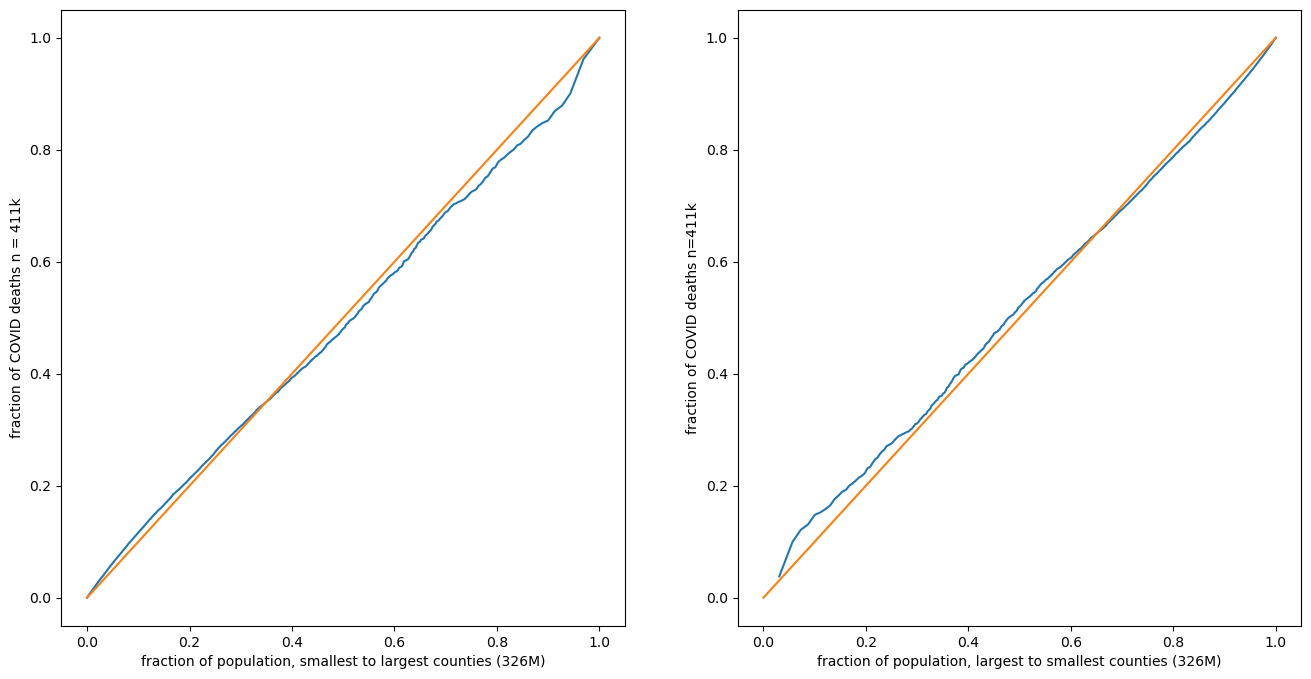

In [169]:
# add line at constant-fraction-population-deaths

plt.figure(figsize=(16,8))
plt.subplot(121);
plt.plot( feb.sort_values("population", ascending=True).population.cumsum() / feb.population.sum(), feb.sort_values("population", ascending=True).deaths.cumsum()/feb.deaths.sum())
plt.xlabel("fraction of population, smallest to largest counties (326M)")
plt.ylabel("fraction of COVID deaths n = 411k")

plt.plot([0,1],[0,1])
plt.subplot(122)
plt.plot( feb.sort_values("population", ascending=False).population.cumsum() / feb.population.sum(), feb.sort_values("population", ascending=False).deaths.cumsum()/feb.deaths.sum())
plt.xlabel("fraction of population, largest to smallest counties (326M)")
plt.ylabel("fraction of COVID deaths n=411k")

plt.plot([0,1],[0,1])

In [ ]:
# This is an honest visualization, but 
# I was not expecting to see this.  

# All right, I was shocked that the effect size seems so small.

In [ ]:
# The effect is real, but seems smaller than we were led to believe.  (Hard to judge from graph)
# Note these two graphs have the same shape, just flipped up and down and left and right.
# On the right-hand graph, we see that large counties are in fact harder hit, 
# and that the third of the population in the smallest counties had lower-than-overall
# death rates.   

# Hmm.  How to make this deceptive?  

# A:  Sort by after-the-fact deaths by county (something you should never do)


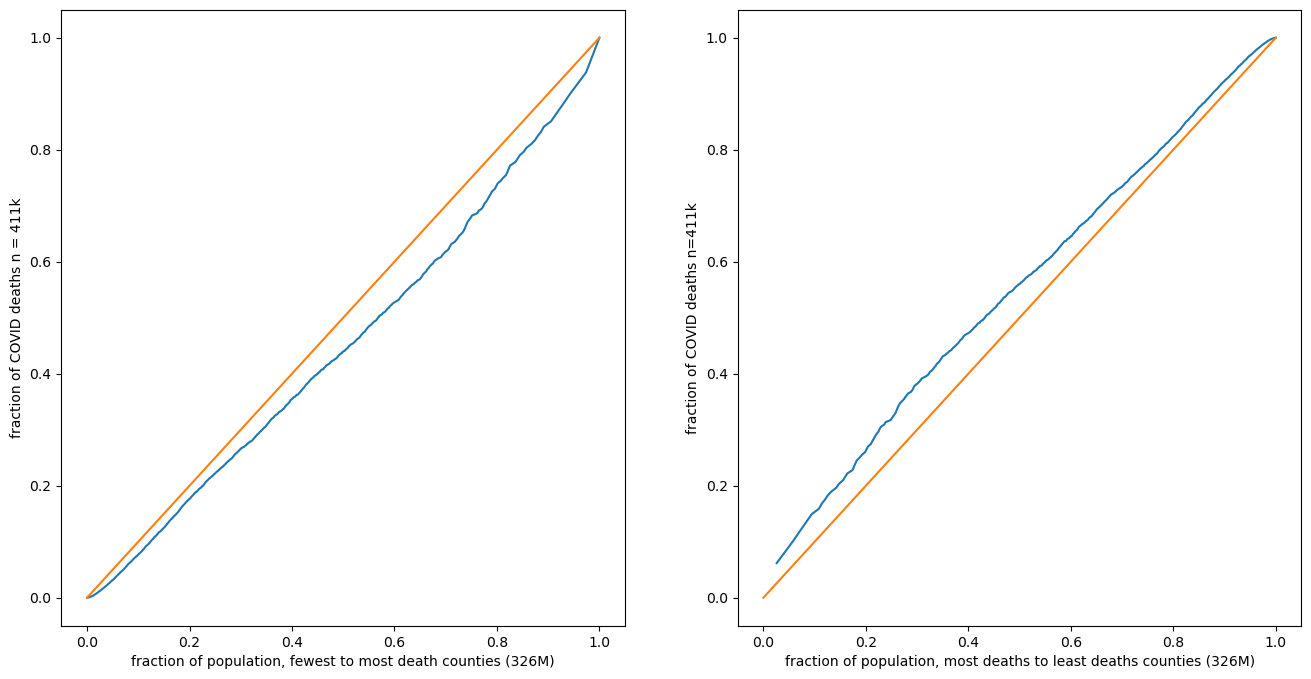

In [170]:
plt.figure(figsize=(16,8))
plt.subplot(121);
plt.plot( feb.sort_values("deaths", ascending=True).population.cumsum() / feb.population.sum(), feb.sort_values("deaths", ascending=True).deaths.cumsum()/feb.deaths.sum())
plt.xlabel("fraction of population, fewest to most death counties (326M)")
plt.ylabel("fraction of COVID deaths n = 411k")

plt.plot([0,1],[0,1])
plt.subplot(122)
plt.plot( feb.sort_values("deaths", ascending=False).population.cumsum() / feb.population.sum(), feb.sort_values("deaths", ascending=False).deaths.cumsum()/feb.deaths.sum())
plt.xlabel("fraction of population, most deaths to least deaths counties (326M)")
plt.ylabel("fraction of COVID deaths n=411k")

plt.plot([0,1],[0,1])

In [171]:
# This is not as dramatic as I was expecting. 
# Let's see if it matches.
#  65 counties most deaths - 31.9% US population 40.3% of deaths

heritage = pd.DataFrame( {
"fracdeaths": feb.sort_values("deaths", ascending=False).deaths.cumsum() / feb.deaths.sum(),
"fracpopulation": feb.sort_values("deaths", ascending=False).population.cumsum() / feb.population.sum()
})

In [172]:
heritage.index = np.arange(len(heritage))

In [173]:
heritage

,fracdeaths,fracpopulation
0,0.061767,0.025946
1,0.099936,0.056975
2,0.121272,0.073026
3,0.138255,0.086098
4,0.149349,0.094442
...,...,...
3130,1.000000,0.999952
3131,1.000000,0.999961
3132,1.000000,0.999987
3133,1.000000,1.000000


In [ ]:
heritage.loc[64]

In [ ]:
heritage.loc[60]

In [ ]:
#  65 counties most deaths - 31.9% US population 40.3% of deaths
# This is a size of error that might be caused by consolidating 
# NYC's five boroughs.. 

# The difference at 40.3% of deaths is 0.5% of US population, 
# which is a difference of a county (or borough) of 1.6M population.
# This isn't far enough off to make me sound the alarm.  

# The deception was in sorting by the outcome of a random process.

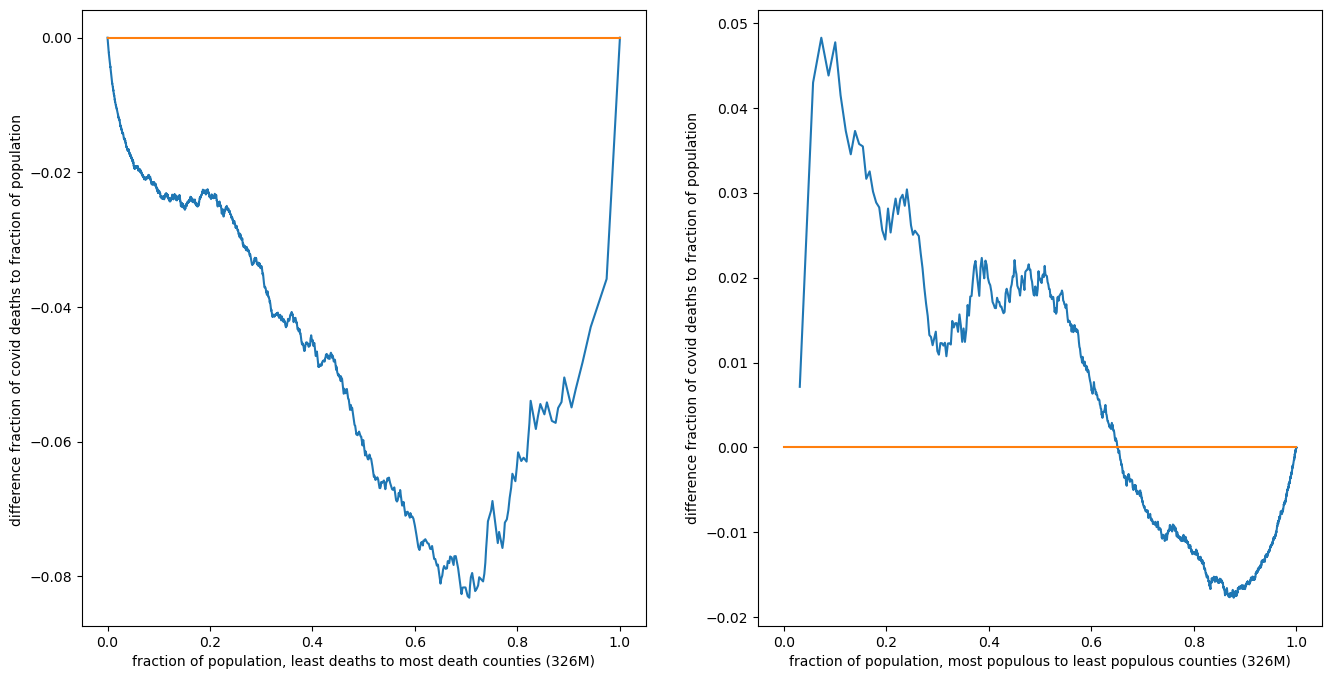

In [174]:
# Maybe I can plot the difference betwen fraction population and 
# fraction of deaths?
plt.figure(figsize=(16,8))
plt.subplot(121);
plt.plot( feb.sort_values("deaths", ascending=True).population.cumsum() / feb.population.sum(),    feb.sort_values("deaths", ascending=True).deaths.cumsum()/feb.deaths.sum()- feb.sort_values("deaths", ascending=True).population.cumsum() / feb.population.sum())
plt.xlabel("fraction of population, least deaths to most death counties (326M)")
plt.ylabel("difference fraction of covid deaths to fraction of population ")

plt.plot([0,1],[0,0])
plt.subplot(122)
plt.plot( feb.sort_values("population", ascending=False).population.cumsum() / feb.population.sum(), feb.sort_values("population", ascending=False).deaths.cumsum()/feb.deaths.sum()- feb.sort_values("population", ascending=False).population.cumsum()/feb.population.sum( ))
plt.xlabel("fraction of population, most populous to least populous counties (326M)")
plt.ylabel("difference fraction of covid deaths to fraction of population")
plt.plot([0,1],[0,0])



In [ ]:
# And this relationship on the left was treated with a slider that
# ran from 0 to 5% of population, and with another slider for the n
# most-death counties that ran from 52% to 89%. 

Text(0, 0.5, 'Number of counties')

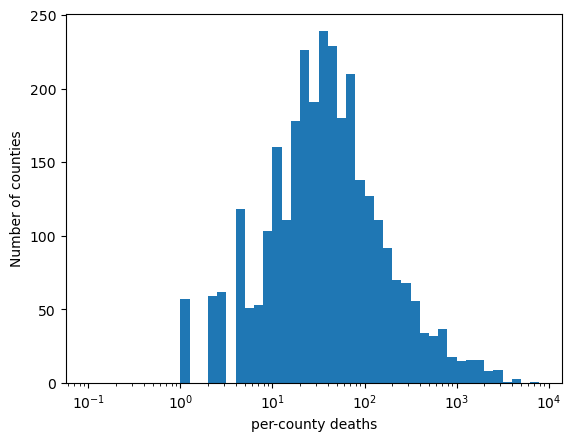

In [175]:
# Let us consider that histogram of per-county deaths..
# It was weighted such that each county got one vote. 
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(febdata.deaths , bins=bins )
plt.xscale("log")
plt.xlabel("per-county deaths")
plt.ylabel("Number of counties")

Text(0, 0.5, 'population in affected counties')

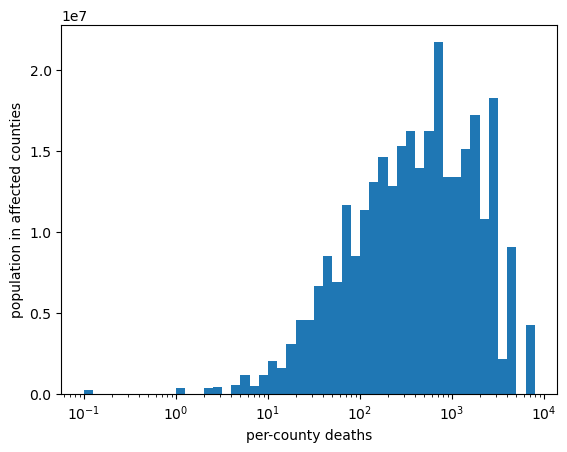

In [176]:
# We can add weights to the histogram to count people
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(feb.deaths+.1 , bins=bins, weights=feb.population )
plt.xscale("log")

plt.xlabel("per-county deaths")
plt.ylabel("population in affected counties")

Text(0, 0.5, 'affected population')

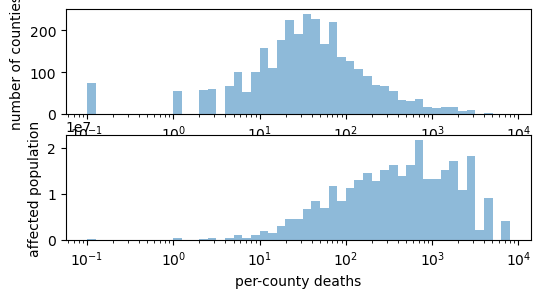

In [178]:
# And plot them at the same time
plt.figure(figsize=(6,3))
plt.subplot(211)
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(feb.deaths+.1 , bins=bins, alpha=0.5 )
plt.xscale("log")
plt.xlabel("per-county deaths")
plt.ylabel("number of counties")
plt.subplot(212)
plt.hist(feb.deaths+.1 , bins=bins, weights=feb.population, alpha=0.5 )
plt.xscale("log")
plt.xlabel("per-county deaths")
plt.ylabel("affected population")



Text(0, 0.5, 'number of counties')

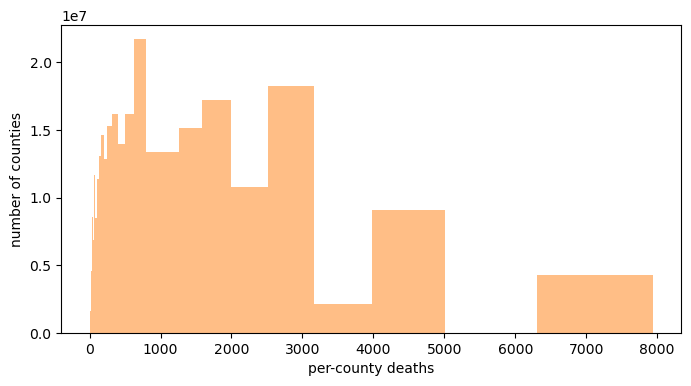

In [179]:
# And plot them at the same time
plt.figure(figsize=(8,4))
bins = np.power(10, np.arange(-1,4,.1) )
plt.hist(feb.deaths+.1 , bins=bins, alpha=0.5 )
plt.hist(feb.deaths+.1 , bins=bins, weights=feb.population, alpha=0.5 )

#plt.xscale("log")
plt.xlabel("per-county deaths")
plt.ylabel("number of counties")

In [ ]:
# These don't look as similar as one might want them to be.
# The median county has 30 deaths but the median citizen 
# lives in a county with 300 deaths.  

# Counting by county is bad.

Text(0.5, 0, 'per capita COVID deaths (by population)')

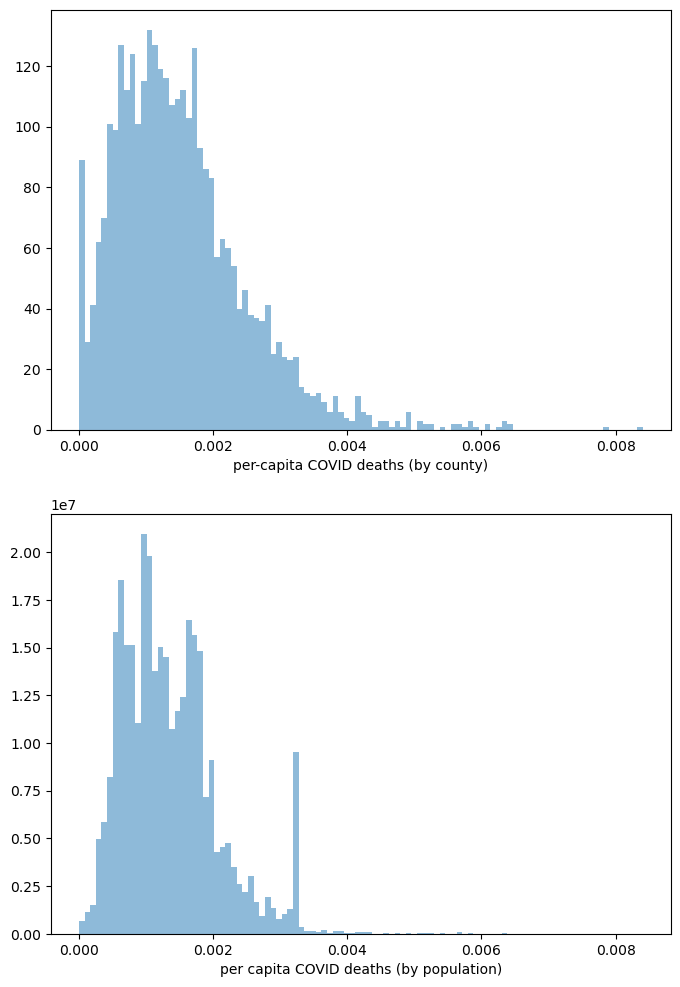

In [180]:
#rates?
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.hist(feb.percapitadeaths , alpha=0.5, bins=100 )
plt.xlabel("per-capita COVID deaths (by county)")
plt.subplot(212)
plt.hist(feb.percapitadeaths , weights=feb.population, alpha=0.5 , bins=100)
plt.xlabel("per capita COVID deaths (by population)")

In [181]:
# The effect here is not as strong, or is harder to see, but 
# this is the graph whose mean tells you how bad it is on average.

# For kicks, let's calculate the center of mass of these two histograms..
print ("Average crude death rate, weighted by county   ", feb.percapitadeaths.mean())
print ("Average crude death rate, weigted by population", (feb.percapitadeaths * feb.population).sum() / feb.population.sum())

Average crude death rate, weighted by county    0.0015072623295247214
Average crude death rate, weigted by population 0.001350062554097751


In [ ]:
# Couldn't have seen that difference just looking at ragged histograms

In [ ]:
# I feel inspired to make variable-width bar charts from this death data. 

In [182]:
# First, let me define some dummy data, and make sure I can plot this like a set
# of boxes piled up in a mail room.
d = pd.DataFrame ( {
"x": [ 1,1,1,2,1,2,1,2,1,2],
"y": [ 1,1,1,2,1,2,4,3,4,3]
})

<BarContainer object of 10 artists>

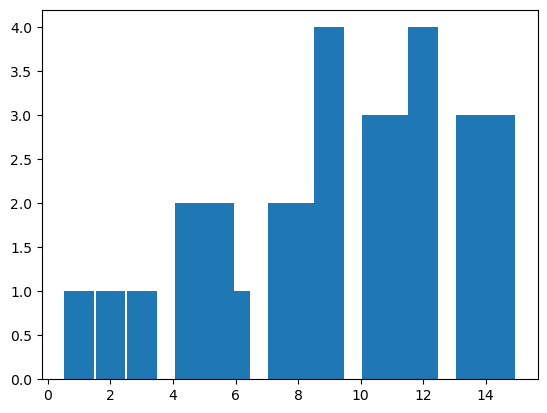

In [184]:
plt.bar(d.x.cumsum(),d.y, width=.95*d.x)

In [185]:
# This does not look right; there are gaps between the boxes.  And the first box starts at 0.5, not at 0.
d.x.cumsum()

0     1
1     2
2     3
3     5
4     6
5     8
6     9
7    11
8    12
9    14
Name: x, dtype: int64

In [ ]:
# I want my x's to start at zero..

In [186]:
# create a dataframe for the x offsets
d["xoff" ] = d.x.cumsum()[:]

xoff  = d[["xoff", "y"]]
xoff

,xoff,y
0,1,1
1,2,1
2,3,1
3,5,2
4,6,1
5,8,2
6,9,4
7,11,3
8,12,4
9,14,3


<BarContainer object of 10 artists>

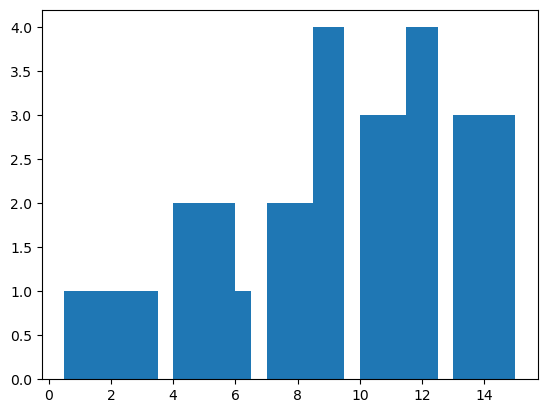

In [187]:
plt.bar(d.xoff, d.y, width=d.x)

In [ ]:
# This is still not right; the middle of the boxes is being aligned with the cumulative sum just below each box.
# The fix for this is plt.bar align="edge"

<BarContainer object of 10 artists>

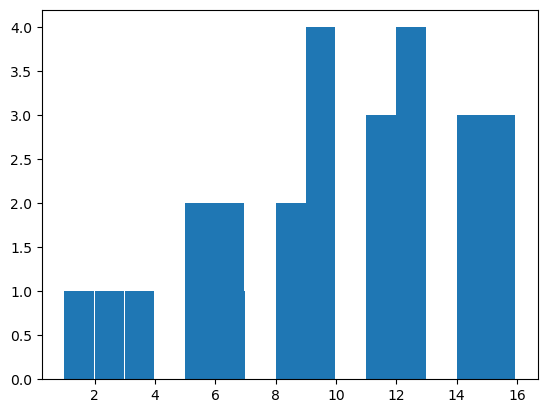

In [188]:
plt.bar(d.xoff, d.y, width=d.x* 0.97, align="edge")

In [ ]:
# so this is my recipe for packing boxes into the moving van:
# prepend data with 0
# take cumulative sum and chop off final value
# set width = values and align = "edge"


In [ ]:
# There was a way to prepend the data with 0 with .shift()... it throws away the last data point.
d

In [ ]:
d.shift(1)

In [189]:
d["xoff"]  = d.shift(1,fill_value=0).xoff

<BarContainer object of 10 artists>

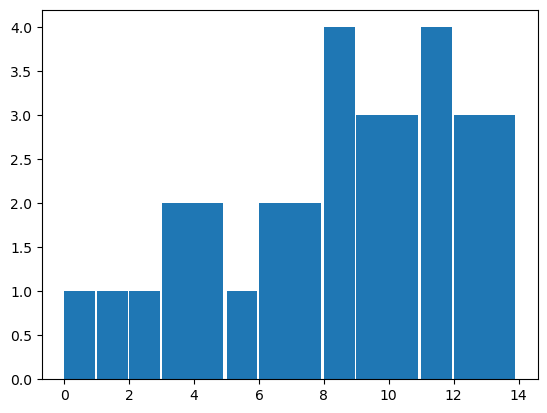

In [190]:
plt.bar(d.xoff, d.y, width=d.x* 0.95, align="edge")

In [ ]:
# Well that seems to do it.  This is my stack of boxes for the moving truck.

Text(0.5, 0, 'US population affected (millions)')

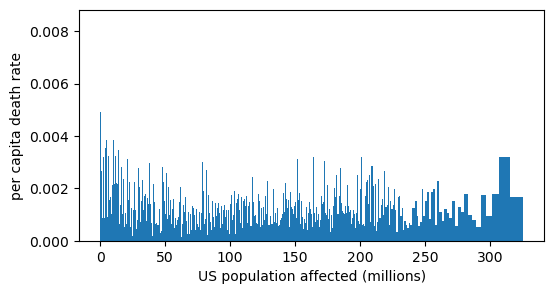

In [192]:
plt.figure(figsize=(6,3))
cumpopoffset = feb.sort_values("population").population.shift(1, fill_value=0).cumsum()
plt.bar(cumpopoffset/1E6, feb.sort_values("population").percapitadeaths, width=feb.sort_values("population").population/1E6, align="edge")
plt.ylabel("per capita death rate")
plt.xlabel("US population affected (millions)")

In [193]:
# This is the death rate vs. county size that matters; the 
# squares use ink proportional to the number of coffins.
# I didn't do a formal statistical test, but I don't see an
# overwhelmingly strong pattern here.

Text(0.5, 0, 'US population affected (millions)')

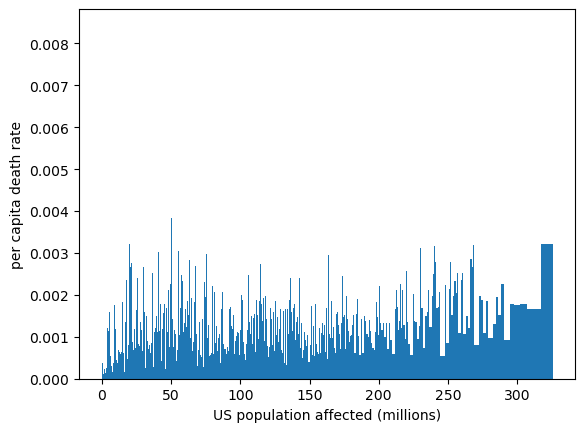

In [194]:
cumdeathoffset = feb.sort_values("deaths").population.shift(1, fill_value=0).cumsum()
plt.bar(cumdeathoffset/1E6, feb.sort_values("deaths").percapitadeaths, width=feb.sort_values("deaths").population/1E6, align="edge")
plt.ylabel("per capita death rate")
plt.xlabel("US population affected (millions)")

Text(0.5, 0, 'US population affected (millions)')

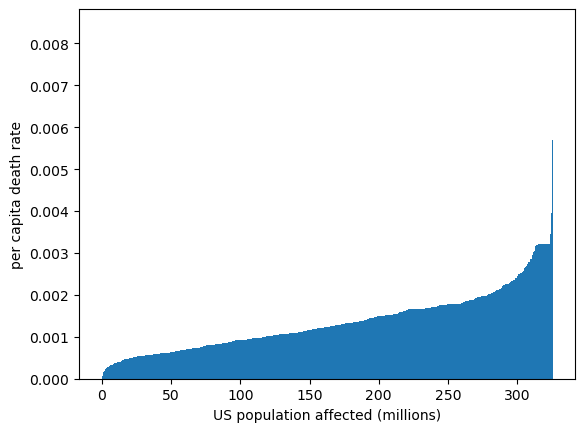

In [195]:
cumpcoffset = feb.sort_values("percapitadeaths").population.shift(1, fill_value=0).cumsum()
plt.bar(cumpcoffset/1E6, feb.sort_values("percapitadeaths").percapitadeaths, width=feb.sort_values("percapitadeaths").population/1E6, align="edge")
plt.ylabel("per capita death rate")
plt.xlabel("US population affected (millions)")

In [ ]:
# And I show you this lovely S-shape as a warning, that when you see it, you 
# might remember that it represents random data that has been sorted, and that it
# represents lies.

In [ ]:
feb.head()

In [ ]:
# How many counties with 0 deaths?
(feb.deaths == 0 ).sum()

In [196]:
# How many counties with only 1 death?
(feb.deaths == 1 ).sum()

55